## Fitting with our dataset

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import gepard as g # NeuralModel with Dispersion relation added 
from gepard import model, fitter, data, plots
import gepard.plots as gplot
from gepard.fits import GLO15new, AUTIpts, ALUIpts
print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11b0


In [3]:
import gmaster as gm
from gmaster.fits import th_KM15, th_KM10b # need KM15 for simulated data
th15 = th_KM15
from gmaster.constants import Mp2, toTeX

In [4]:
import torch
import numpy as np 
#np.set_printoptions(legacy='1.25')
import matplotlib
import matplotlib.pyplot as plt
import shelve, logging, copy
logging.basicConfig(level=logging.ERROR) 
import pandas as pd 
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm

### To add our data files to gepard


In [5]:
sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/')
#sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepardTorch/gepard/src/gtorch')
import mydatafiles
from mydatafiles import ep2epgamma

mydset = g.data.loaddata(mydatafiles)
mydset.update(g.data.loaddata(ep2epgamma))

In [6]:
# To have nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : '\n'.join([r'\usepackage{amssymb}', r'\usepackage{amsmath}'])}
plt.rcParams.update(params)

In [7]:
fitpoints = mydset[182] + mydset[192] + g.dset[101] + g.dset[102] + g.dset[8]
g.describe_data(fitpoints)

#fitpoints1 =  g.dset[8] + g.dset[101] + g.dset[102] 
#g.describe_data(fitpoints1)

# g.dset[7] it worked 
# g.dset[6] didn't work 
# g.dset[82] , mydset[325], mydset[98], dset[91] did not work

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
31 x ALU     CLAS    -1     182 arxiv.org/pdf/2211.11274
11 x ALU     CLAS    -1     192 arxiv:2211.11274
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 198


In [8]:
# For easier manipulations we transform some datasets to pandas frames
data = mydset[182]
BSA = data.df()   # ALU by CLAS 2022
data = g.dset[102]
BSS = data.df()  # CLAS 2015
data = g.dset[101]
BSD = data.df()  # CLAS 2015

In [9]:
# Bins can be defined as ranges within the following limiting values:
tmlims = [0, 0.13, 0.18, 0.22, 0.3, 0.4, 0.5]
xilims = [0, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.26]

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

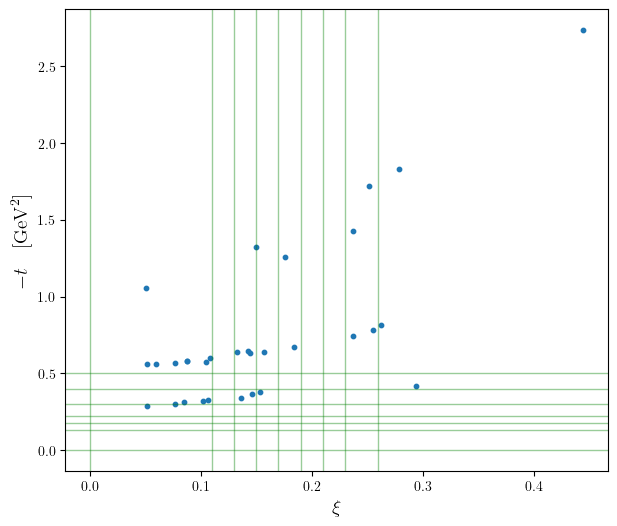

In [10]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSA.xi, BSA.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

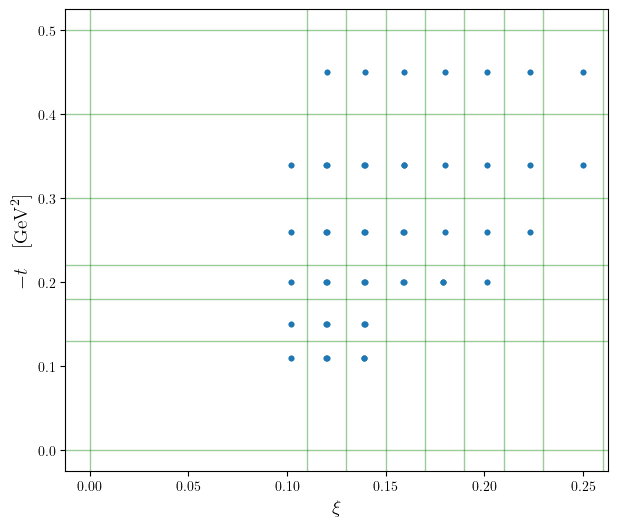

In [11]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSS.xi, BSS.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

Text(0, 0.5, '$-t\\quad[{\\rm GeV}^2]$')

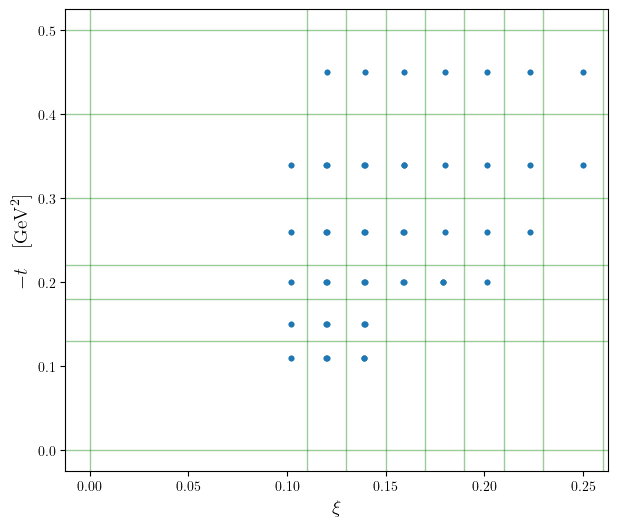

In [12]:
fig, ax = plt.subplots(figsize=[7,6])
ax.scatter(BSS.xi, BSS.tm, s=10)
for tm in tmlims:
    ax.axhline(tm, color='g', linewidth=1, alpha=0.4)
for xi in xilims:
    ax.axvline(xi, color='g', linewidth=1, alpha=0.4)
ax.set_xlabel(r'$\xi$', fontsize=14)
ax.set_ylabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)

## Fit with NeuralModel

In [13]:
#class NNTest(g.model.NeuralModel, g.eff.KellyEFF, g.dvcs.BM10tw2):
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BMK):    

    def build_net(self):
            '''Overriding the default architecture and optimizer'''
            nn_model = torch.nn.Sequential(
                    torch.nn.Linear(2, 23),
                    torch.nn.ReLU(),
                    torch.nn.Linear(23, 37),
                    torch.nn.ReLU(),
                    torch.nn.Linear(37, 19),
                    torch.nn.ReLU(),
                    torch.nn.Linear(19, len(self.output_layer))
                )
            optimizer = torch.optim.Rprop(nn_model.parameters(), lr=0.01 ) #lr=0.05 #2e-3
            return nn_model, optimizer

In [14]:
g.describe_data(fitpoints)
th = NNTest(output_layer=['ImH', 'ReH']) # , q2in=True) q2in not implemented yet
print(th.useDR)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
31 x ALU     CLAS    -1     182 arxiv.org/pdf/2211.11274
11 x ALU     CLAS    -1     192 arxiv:2211.11274
12 x ALU     CLAS    -1.0   8   arXiv:0711.4805
48 x XLUw    CLAS    -1     101 arXiv:1504.02009
48 x XUUw    CLAS    0.0    102 arXiv:1504.02009
48 x XUUw    CLAS    1.0    102 arXiv:1504.02009
----------------------------------------------
TOTAL = 198
None


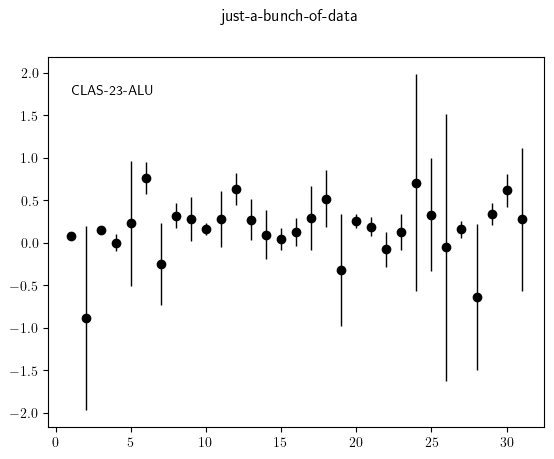

In [15]:
fig = gplot.jbod(points=mydset[182])

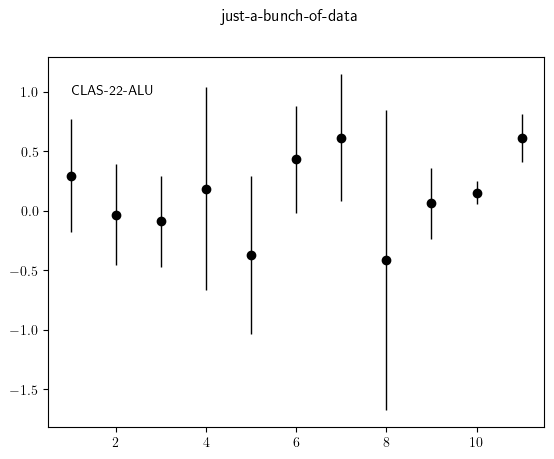

In [16]:
fig = gplot.jbod(points=mydset[192])

In [17]:
#f = g.fitter.NeuralFitter(fitpoints, th, nnets=5, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
#f.fitgood()
f = g.fitter.NeuralFitter(fitpoints, th, nnets=10, nbatch=50, batchlen=3, regularization='L2', lx_lambda=0.01)
f.fit()
torch.save(th.nets, 'Test_dataset1_nets.tar')

/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch   3: train error = 9.0340 test error = 4.8742 -
Epoch   6: train error = 5.1815 test error = 2.4644 -
Epoch   9: train error = 2.7472 test error = 2.2890 -
Epoch  12: train error = 2.1258 test error = 2.1571 -
Epoch  15: train error = 2.0715 test error = 1.3775 -
Epoch  18: train error = 1.9389 test error = 1.3481 -
Epoch  21: train error = 1.8752 test error = 1.3707 +
Epoch  24: train error = 1.8264 test error = 1.3720 +
Epoch  27: train error = 1.7915 test error = 1.2741 -
Epoch  30: train error = 1.7612 test error = 1.3209 +
Epoch  33: train error = 1.7274 test error = 1.2904 +
Epoch  36: train error = 1.7038 test error = 1.3638 +
Epoch  39: train error = 1.6860 test error = 1.3100 +
Epoch  42: train error = 1.6703 test error = 1.3390 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.2741105035577305

Epoch   3: train error = 8.7292 test error = 5.8013 -
Epoch   6: train error = 3.8280 test error = 1.9428 -
Epoch   9: train error = 2.1655 test error = 1.6

### Use shelve to store the trained models

In [18]:
with shelve.open("Models") as shelve_file:
    # Store num list in shelf file 
    
    shelve_file['NoDR'] = th.nets
    NoDR=shelve_file['NoDR']  

    th4 = NNTest(output_layer=['ImH', 'ReH'])
    th4.nets = NoDR  
    print(f"Keys = {list(shelve_file.keys())}")

Keys = ['DR_HE', 'NoDR', 'DR']


### Chi square

In [19]:
th.chisq(fitpoints)

(np.float64(92.20236518162147), 198, np.float64(0.9999999999904187))

### Just a bunch of data with mydataset

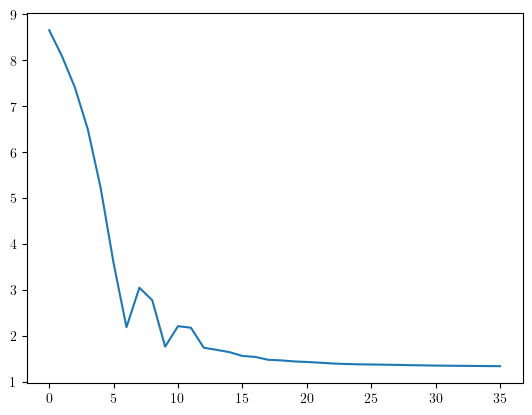

Fit on CLAS data


In [20]:
plt.figure()
plt.plot(f.history)
plt.show()
th.name = "Fit on CLAS data"
print(th.name)

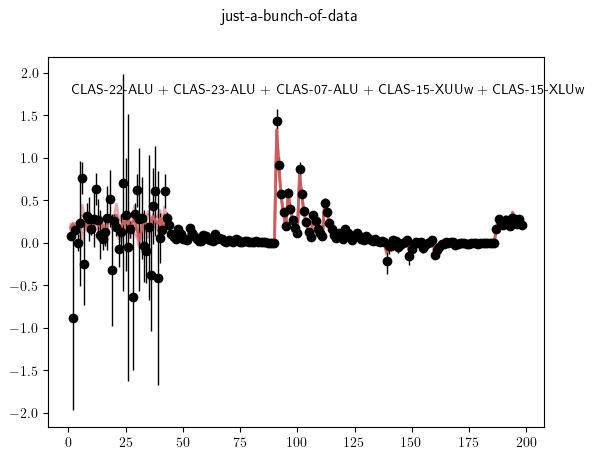

In [21]:
fig = gplot.jbod(points=fitpoints, lines=[th], bands=[th])

### CFFs plots in the no DR case

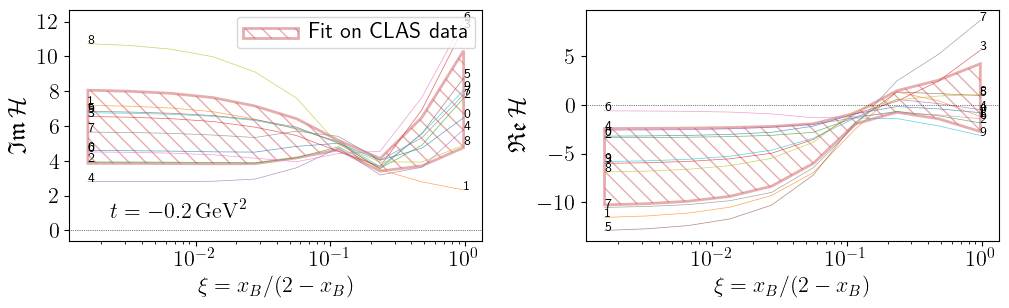

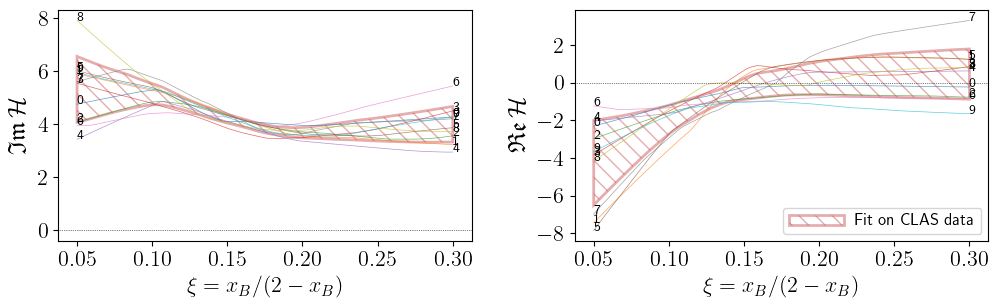

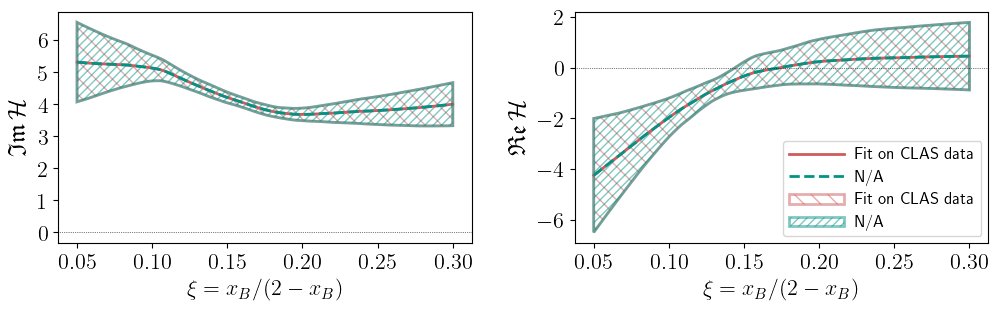

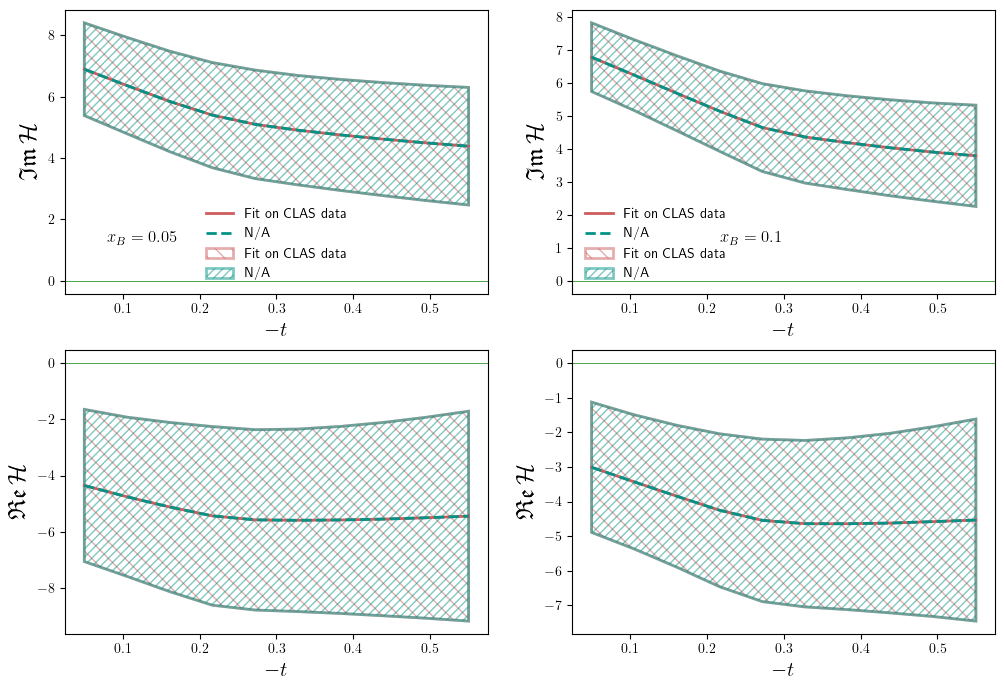

In [22]:
#fig = gplot.CFF3(cffs=['ImH', 'ReH'],  bands=[th], tval=-0.2)
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th, bands=[th], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th, bands=[th])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th4], bands=[th, th4])
#fig.savefig('NN-mesh.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

## Custom NN

In [23]:
import torch.nn as nn
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)  # 2 input features, 12 hidden units
        self.n2 = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3 = nn.Linear(25, 1)  # 7 hidden units, 1 output features
        
        self.n1p = nn.Linear(1, 20)  # 2 input features, 12 hidden units
        self.n2p = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3p = nn.Linear(25, 1)  # 17 hidden units, 1 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

### Create the class inheriting from DispersionCFF

In [24]:
class NNTest_DR(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.01)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(1, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.zero(pt)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [25]:
th2 = NNTest_DR(output_layer=['ImH', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [26]:
#f = g.fitter.NeuralFitter(fitpoints, th2, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
#f.fitgood()
f = g.fitter.NeuralFitter(fitpoints, th2, nnets=10, nbatch=50, batchlen=5, regularization='L2', lx_lambda=0.001)
f.fit()
torch.save(th2.nets, 'Test_dataset2_nets.tar')

/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch   5: train error = 5.8759 test error = 8.1559 -
Epoch  10: train error = 3.6732 test error = 4.1392 -
Epoch  15: train error = 1.6457 test error = 1.5336 -
Epoch  20: train error = 1.5061 test error = 6.5986 +
Epoch  25: train error = 1.4348 test error = 1.3348 -
Epoch  30: train error = 1.3410 test error = 1.5655 +
Epoch  35: train error = 1.2780 test error = 1.9014 +
Epoch  40: train error = 1.2267 test error = 2.0081 +
Epoch  45: train error = 1.1970 test error = 1.9058 +
Epoch  50: train error = 1.1768 test error = 1.9648 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.334813930552842

Epoch   5: train error = 6.6810 test error = 4.5515 -
Epoch  10: train error = 1.9164 test error = 2.2684 -
Epoch  15: train error = 1.5187 test error = 1.7978 -
Epoch  20: train error = 1.4010 test error = 1.5040 -
Epoch  25: train error = 1.3583 test error = 1.5383 +
Epoch  30: train error = 1.3461 test error = 1.5254 +
Epoch  35: train error = 1.3235 test error = 1.52

In [27]:
# Use shelve to store the trained models
with shelve.open("Models") as shelve_file:
    # Store num list in shelf file 
    shelve_file['DR'] = th2.nets
    DR=shelve_file['DR']    
    print(f"Keys = {list(shelve_file.keys())}")

Keys = ['DR_HE', 'NoDR', 'DR']


In [28]:
th2.chisq(fitpoints)

(np.float64(85.33462140942585), 198, np.float64(0.9999999999998687))

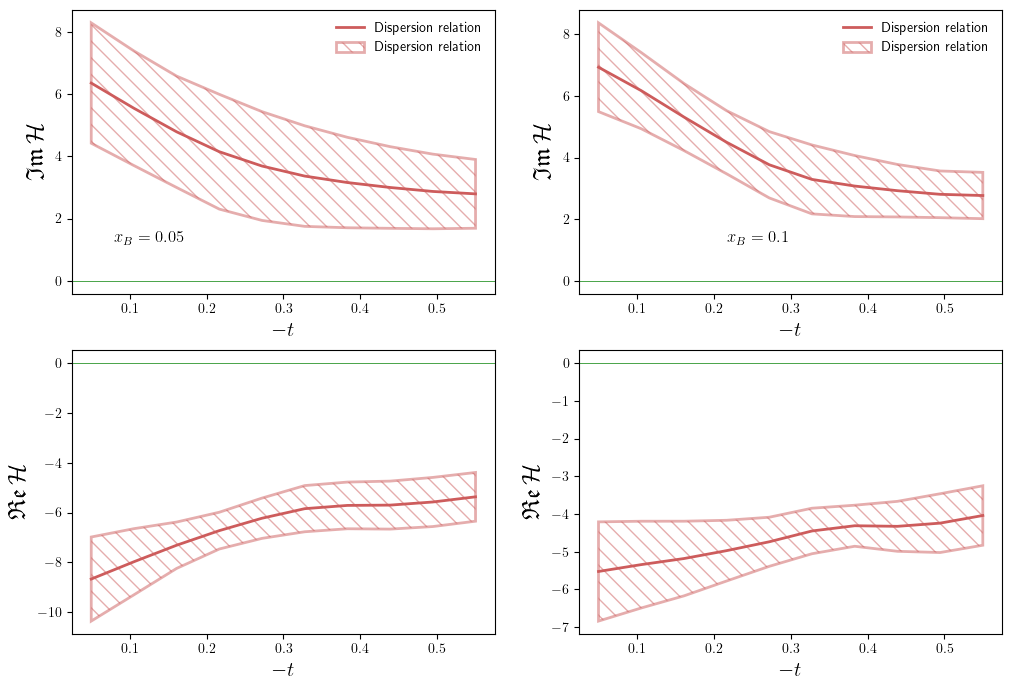

In [29]:
th2.name = "Dispersion relation"
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=th2, bands=[th2])

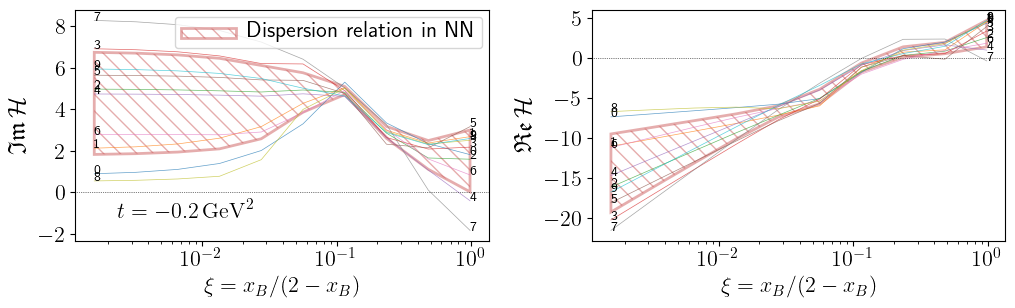

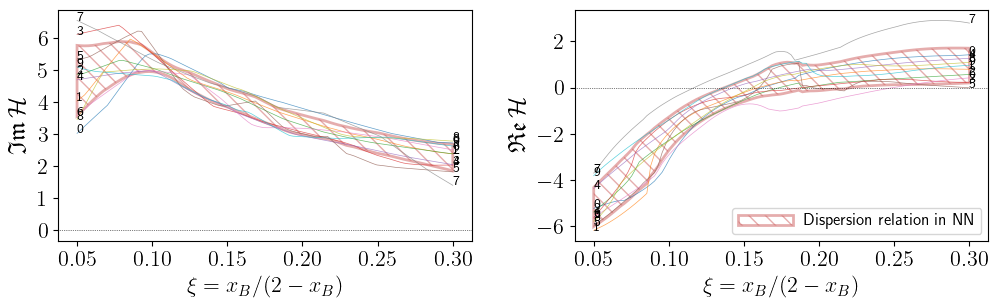

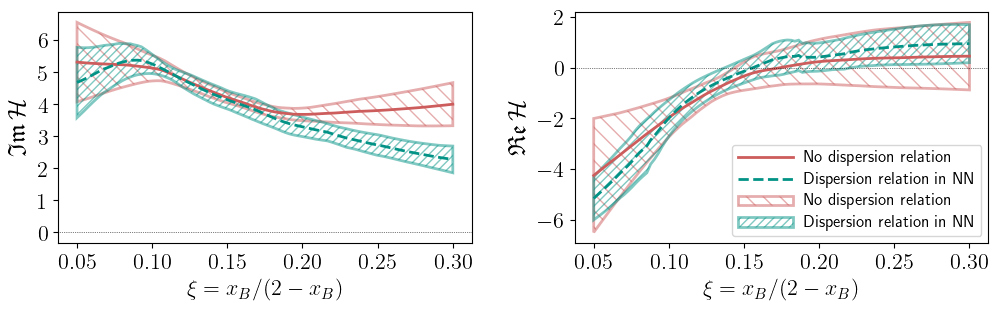

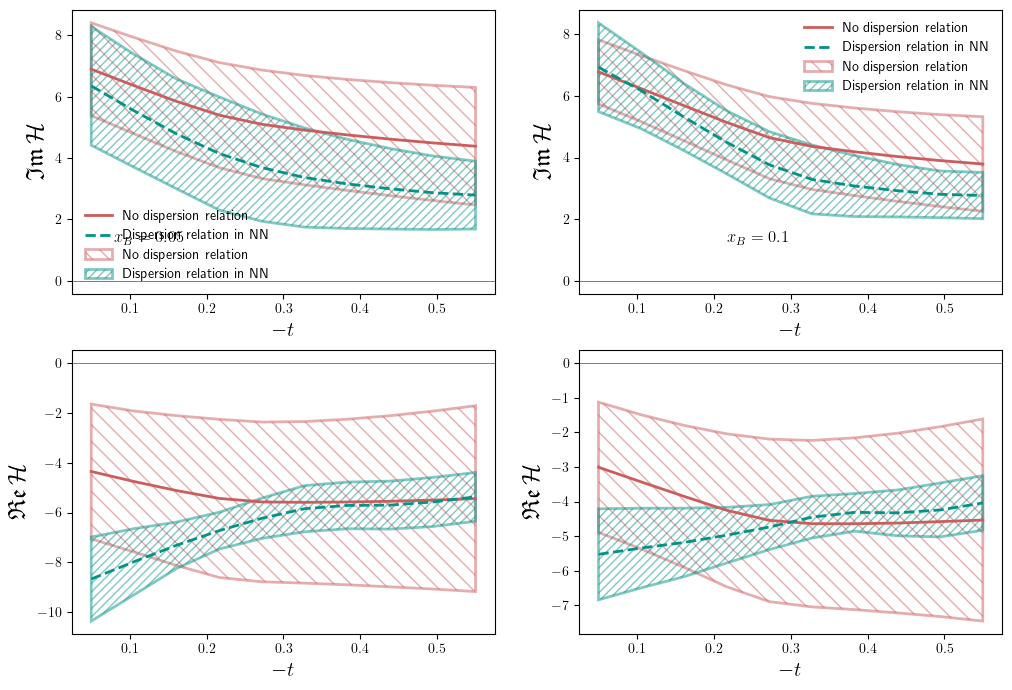

In [30]:
th.name = "No dispersion relation"
th2.name = "Dispersion relation in NN"
fig = gplot.CFF3log(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  mesh=th2, bands=[th2])
fig = gplot.CFF3(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])
fig = gplot.CFFt(cffs=['ImH', 'ReH'],  lines=[th, th2], bands=[th, th2])

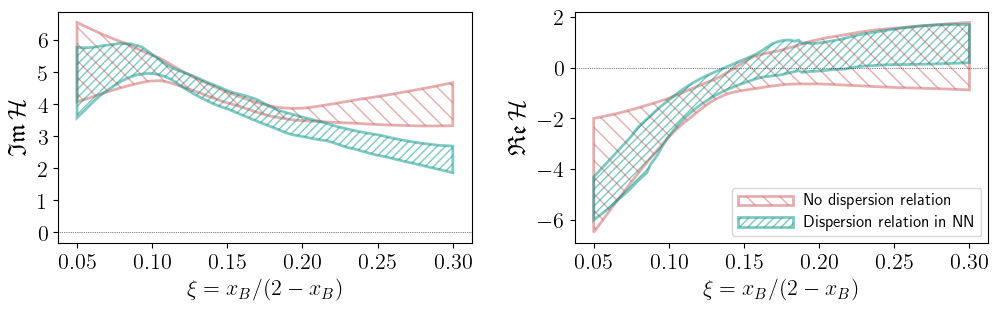

In [31]:
fig = gplot.CFF3(cffs=['ImH', 'ReH'], bands=[th, th2])

## Test with 4 CFFs

In [32]:
class CustomNetwork_4(nn.Module):
    def __init__(self):
        super(CustomNetwork_4, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)  # 2 input features, 7 hidden units
        self.n2 = nn.Linear(20, 25)  # 7 hidden units, 7 hidden units
        self.n3 = nn.Linear(25, 2)  # 7 hidden units, 2 output features
        
        self.n1p = nn.Linear(1, 20)  # 2 input features, 7 hidden units
        self.n2p = nn.Linear(20, 25)  # 7 hidden units, 7 hidden units
        self.n3p = nn.Linear(25, 1)  # 7 hidden units, 2 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

In [33]:
class NNTest_DR_4(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BMK, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork_4()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.05)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        #print("I am here in D")
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

In [34]:
th3 = NNTest_DR_4(output_layer=['ImH', 'ImE', 'D'])#'ImH', 'ReH', 'ImE', 'ReE', 'ImHt', 'ReHt', 'ImEt', 'ReEt'])#

In [35]:
#f = g.fitter.NeuralFitter(fitpoints, th3, nnets=10, maxtries=100, nbatch=6, batchlen=10, minprob=0.05)
#f.fitgood()
f = g.fitter.NeuralFitter(fitpoints, th3, nnets=10, nbatch=50, batchlen=5, regularization='L2', lx_lambda=0.001)
f.fit()
torch.save(th3.nets, 'Test_dataset3_nets.tar')


Epoch   5: train error = 4.7312 test error = 2.9162 -
Epoch  10: train error = 2.6509 test error = 2.0007 -
Epoch  15: train error = 1.8886 test error = 1.8651 -
Epoch  20: train error = 1.7584 test error = 1.7613 -
Epoch  25: train error = 1.7129 test error = 1.7393 -
Epoch  30: train error = 1.6751 test error = 1.6265 -
Epoch  35: train error = 1.6538 test error = 1.6470 +
Epoch  40: train error = 1.6341 test error = 1.6476 +
Epoch  45: train error = 1.6169 test error = 1.6642 +
Epoch  50: train error = 1.5992 test error = 1.6740 +
Epoch  55: train error = 1.5800 test error = 1.7045 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.626539217155441

Epoch   5: train error = 2.5053 test error = 7.1901 -
Epoch  10: train error = 1.5503 test error = 3.5190 -
Epoch  15: train error = 1.3605 test error = 2.8115 -
Epoch  20: train error = 1.2971 test error = 2.7463 -
Epoch  25: train error = 1.2699 test error = 2.7345 -
Epoch  30: train error = 1.2497 test error = 2.71

In [36]:
with shelve.open("Models") as shelve_file:
    # Store num list in shelf file 
    shelve_file['DR_HE'] = th3.nets
    DRHE = shelve_file['DR_HE']
    print(f"Keys = {list(shelve_file.keys())}")

Keys = ['DR_HE', 'NoDR', 'DR']


In [37]:
th3.chisq(fitpoints)

(np.float64(67.94908071357958), 198, np.float64(1.0))

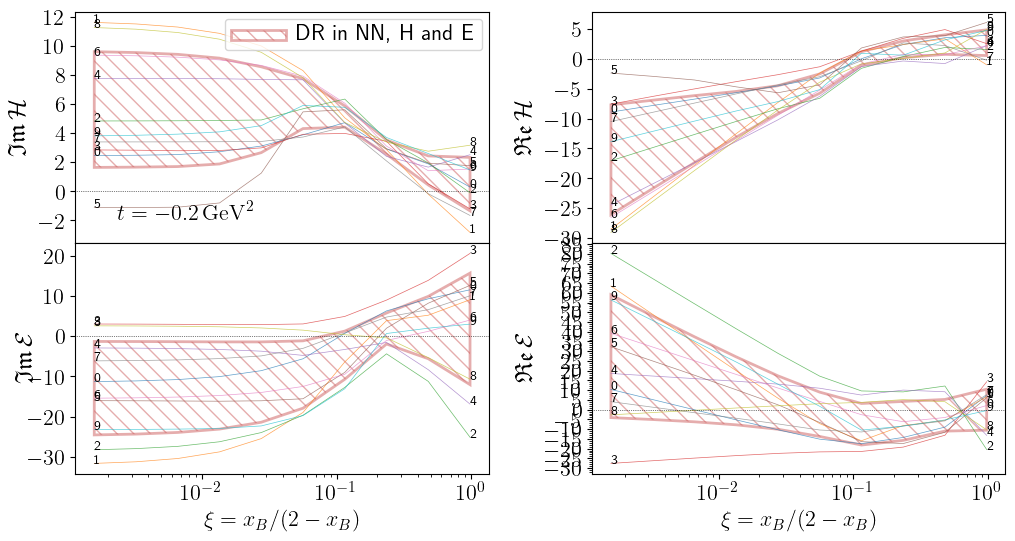

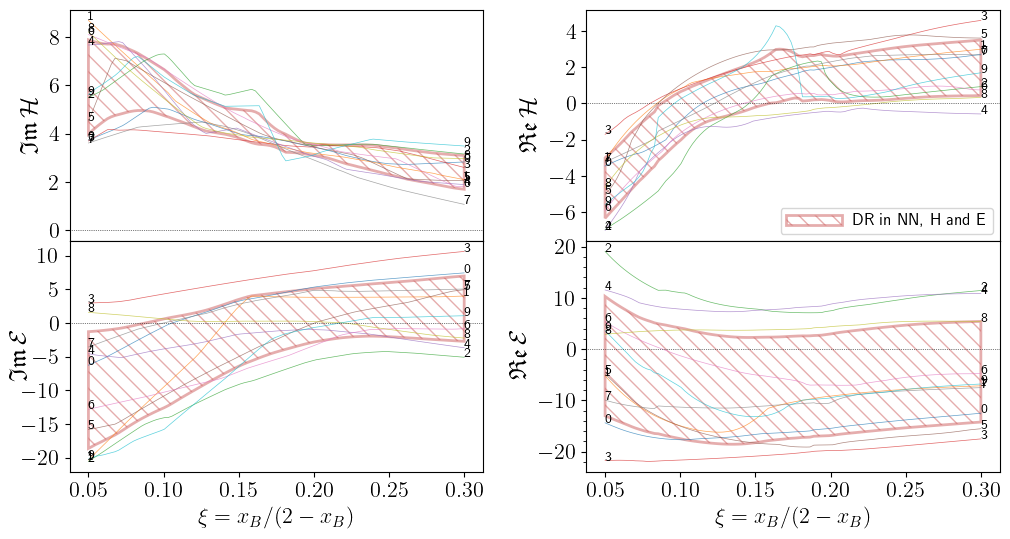

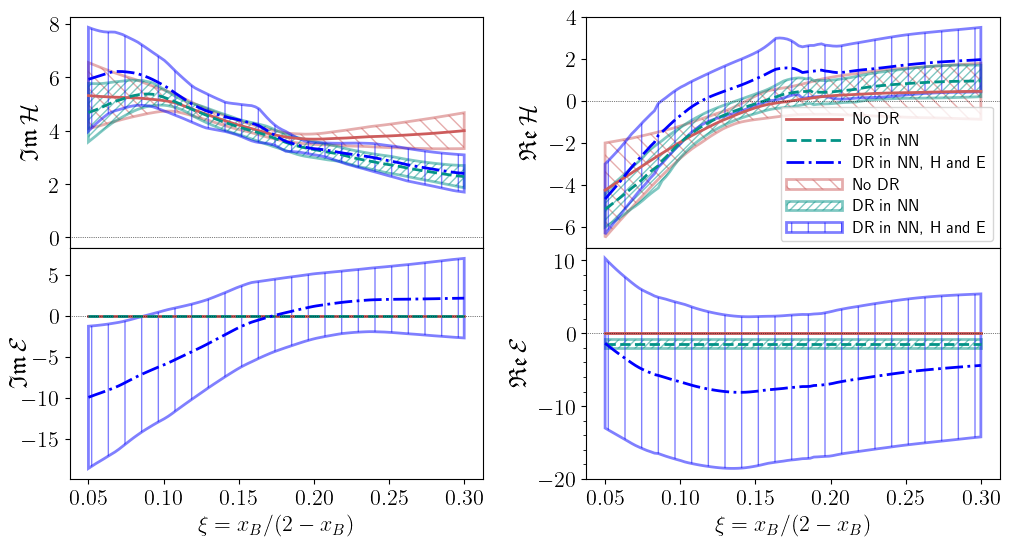

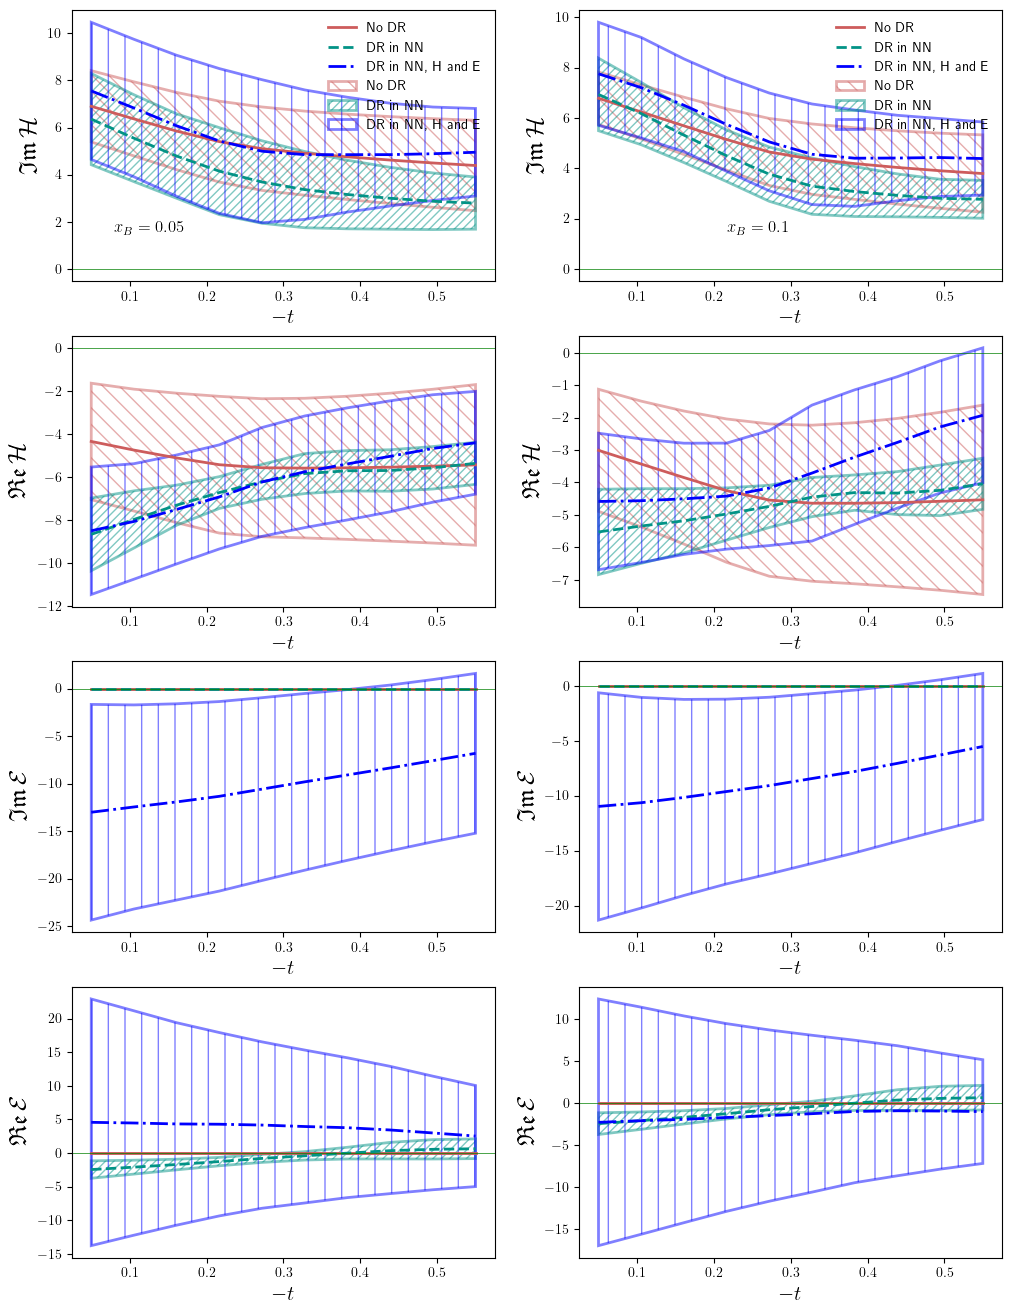

In [38]:
th.name = "No DR"
th2.name = "DR in NN"
th3.name = "DR in NN, H and E"
fig = gplot.CFF3log(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3], tval=-0.2)
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  mesh=th3, bands=[th3])
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])
fig = gplot.CFFt(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th, th2, th3], bands=[th, th2, th3])

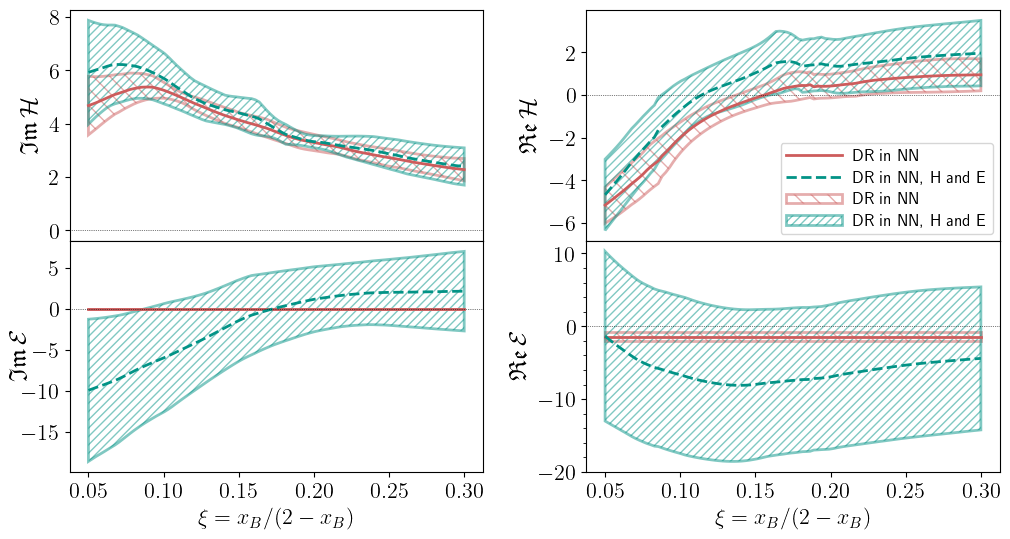

In [39]:
fig = gplot.CFF3(cffs=['ImH', 'ReH', 'ImE', 'ReE'],  lines=[th2, th3], bands=[th2, th3])

### Describing CLAS data of 2015

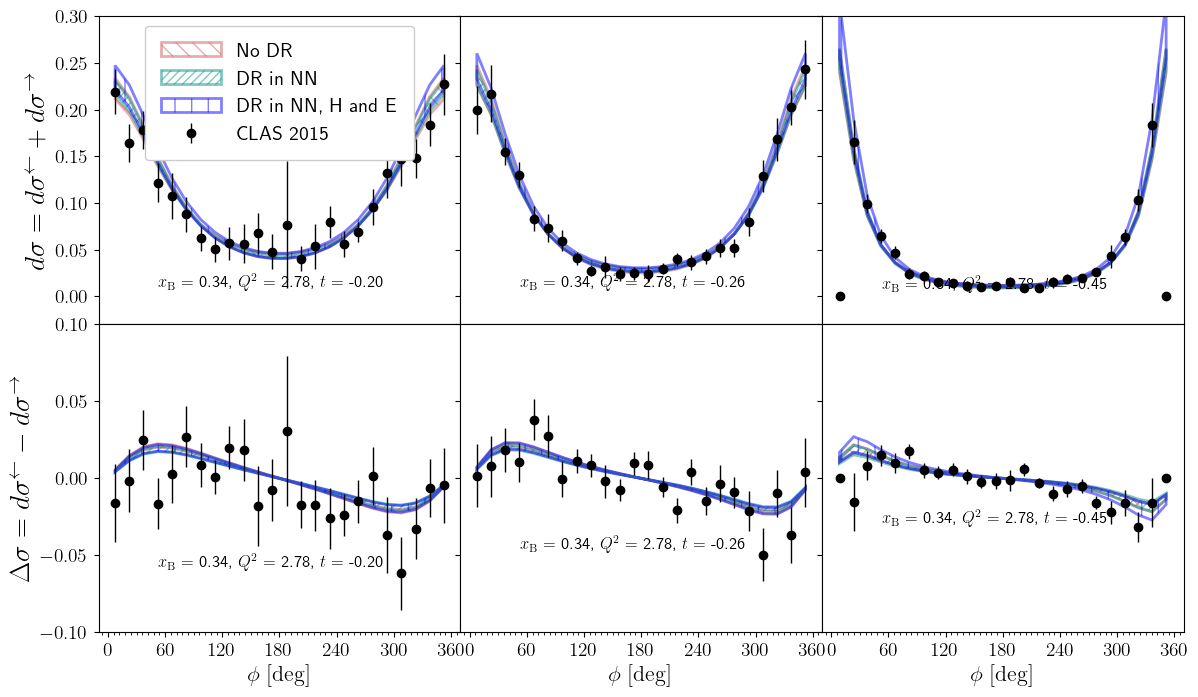

In [40]:
fig = plots.CLAS15phi(bands=[th,th2,th3])

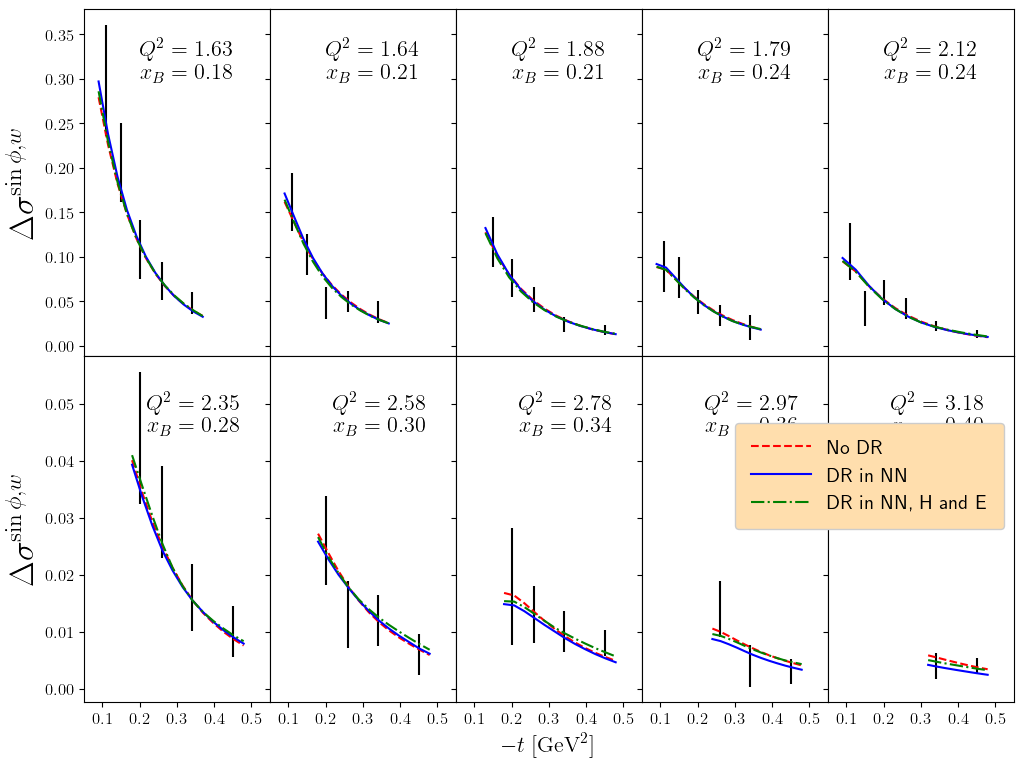

In [41]:
fig = gplot.CLAS15xs(lines=[th,th2,th3])

## D-term using NN

In [42]:
import random
ptts = []
tm_list = np.linspace(0.1, 0.5, 10)#[0.1, 0.2, 0.3, 0.4]

for tm in tm_list:
    #rndm_idx = random.randint(0, len(tm_list)-1) # take some random point and set/change -t
    ptb = g.dset[102][0].copy()  
    ptb.t = -tm
    ptb.tm = tm
    th15.prepare(ptb)
    ptts.append(ptb)


print(ptts)

[DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437, DataPoint: XUUw = 1.437]


In [43]:
th2.name = "DR in NN whit 2 CFFs"
th3.name = "DR in NN with 4 CFFs"

In [44]:
D = []
std_values = [] #!
net_indices = [] #!
for th in [th2, th3]: #[th2]: 
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []
    for pt in ptts[::-1]:
        Ds = []
        for i, net in enumerate(th.nets):  # Loop over neural networks
            th.nn_model, th.nn_mean, th.nn_std = net  # Assign neural net parameters
            
            Ds.append(float(th.m.subtraction(pt).detach().numpy()*18./25.))
            #print(float(-th.m.subtraction(pt).detach().numpy()*18./25.))
            th.cffs_evaluated = False
        net_indices.append(i)
        #for k in range(len(th.m.nets)):
            #th.m.parameters['nnet'] = k
            # NOTE: subtraction in code is equal to -\Delta(t) !
            #Ds.append(-th.m.subtraction(pt).detach().numpy()*18./25.) 
            #print(-th.m.subtraction(pt).detach().numpy()*18./25.)
        Ds = np.array(Ds)
        D_std = Ds.std() #!
        std_values.append(D_std) #!

        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), Ds.std()))
        A.append((pt.tm, Ds.mean(), Ds.std()))
    th.m.parameters['nnet'] = 'ALL'    
    D.append(A)


---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.5: 0.3988194063305855 +- 1.0394809901731152
0.185, -0.4555555555555556: 0.3077230304479599 +- 0.9651976110154061
0.185, -0.4111111111111111: 0.1253555715084076 +- 0.7507175570678728
0.185, -0.3666666666666667: -0.10810758583247662 +- 0.5591440951734945
0.185, -0.32222222222222224: -0.33246019035577773 +- 0.44335788392051334
0.185, -0.2777777777777778: -0.5483356714248657 +- 0.42745833069734224
0.185, -0.23333333333333334: -0.8211749479174614 +- 0.43524894325762103
0.185, -0.18888888888888888: -1.0884440302848817 +- 0.4950190457919938
0.185, -0.14444444444444446: -1.3262420892715454 +- 0.6185639288655792
0.185, -0.1: -1.5466041207313537 +- 0.7623590086434912

---- [DR in NN, H and E - N/A] ----
0.185, -0.5: -1.0781303226947785 +- 1.0581058050791292
0.185, -0.4555555555555556: -1.0233336001634599 +- 1.0052991474313069
0.185, -0.4111111111111111: -0.9835427224636077 +- 0.9276797032019654
0.185, -0.3666666666666667: -0.9515162438154221 +- 0

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_44418/1427647854.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th.m.subtraction(pt).detach().numpy()*18./25.))


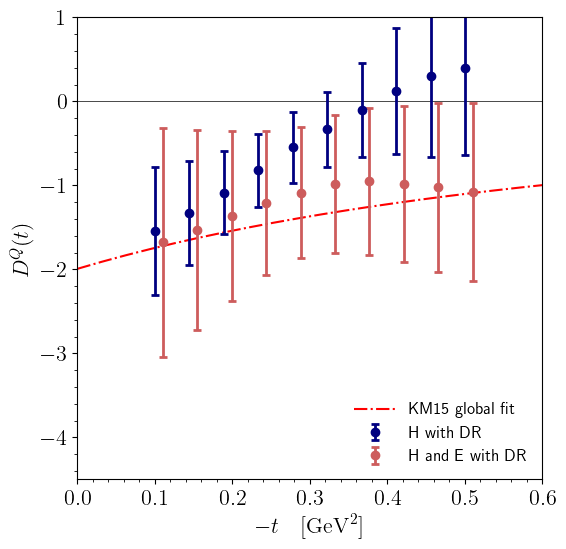

In [46]:
NPTS = 20
ts = np.linspace(0, 0.6, NPTS)
KMS = np.array([-(18./25.)*2.768/(1.+tm/1.204**2)**2 for tm in ts])
CDS = np.array(D[0])
CADS = np.array(D[1])
fig, ax = plt.subplots(1, 1,  figsize=[6,6])
ax.axhline(y=0, linewidth=0.5, color='k')  # y=0 thin line
ax.plot(ts, KMS, 'r-.', label='KM15 global fit')
ax.errorbar(CDS[:,0], CDS[:,1], CDS[:,2], linestyle='None', color='navy',
            elinewidth=2, capsize=3, capthick=2, marker='o', label='H with DR')
ax.errorbar(CADS[:,0,]+0.01, CADS[:,1], CADS[:,2], linestyle='None', elinewidth=2,
            capsize=3, capthick=2, marker='o', color='indianred', label='H and E with DR')

ax.set_xlim(0.0, 0.6)
ax.set_ylim(-4.5, 1)
ax.legend(loc=4, handlelength=2.5,
            prop=matplotlib.font_manager.FontProperties(size="large")
        ).draw_frame(0)
ax.set_xlabel(r'$-t \quad [{\rm GeV}^2]$', fontsize=16)
ax.set_ylabel(r'$D^{Q}(t)$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(0.1)) 
ax.xaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.02)) 
ax.yaxis.set_major_locator(
        matplotlib.ticker.MultipleLocator(1.)) 
ax.yaxis.set_minor_locator(
        matplotlib.ticker.MultipleLocator(0.2)) 

In [77]:
D = []
std_values = []  # Stores standard deviations for all neural nets
mean_std_values = []  # Stores mean standard deviations for each `th`

for th in [th2, th3]:  # Iterate over models (th2, th3)
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    A = []  # Temporary storage for current model data
    for pt in ptts[::-1]:  # Loop over kinematic points
        Ds = []
        for i, net in enumerate(th.nets):  # Loop over neural networks
            th.nn_model, th.nn_mean, th.nn_std = net  # Assign neural net parameters
            Ds.append(float(th.m.subtraction(pt).detach().numpy() * 18. / 25.))
            th.cffs_evaluated = False  # Reset evaluation flag for each net

        Ds = np.array(Ds)
        D_std = Ds.std()
        std_values.append(D_std)  # Collect standard deviation for the current point

        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), D_std))
        A.append((pt.tm, Ds.mean(), D_std))

    # Compute mean standard deviation for the current model
    mean_std = np.mean(std_values)
    mean_std_values.append(mean_std)

    print(f"\nMean Standard Deviation Across All Nets for {th.name}: {mean_std} (using {len(th.nets)} Neural Nets)")
    th.m.parameters['nnet'] = 'ALL'  # Reset to use all nets
    D.append(A)

# Display final mean standard deviations for all models
for th, mean_std in zip([th2, th3], mean_std_values):
    print(f"\nFinal Mean Standard Deviation for {th.name}: {mean_std}")



---- [DR in NN whit 2 CFFs - N/A] ----
0.185, -0.5: 0.3988194063305855 +- 1.0394809901731152
0.185, -0.4555555555555556: 0.3077230304479599 +- 0.9651976110154061
0.185, -0.4111111111111111: 0.1253555715084076 +- 0.7507175570678728
0.185, -0.3666666666666667: -0.10810758583247662 +- 0.5591440951734945
0.185, -0.32222222222222224: -0.33246019035577773 +- 0.44335788392051334
0.185, -0.2777777777777778: -0.5483356714248657 +- 0.42745833069734224
0.185, -0.23333333333333334: -0.8211749479174614 +- 0.43524894325762103
0.185, -0.18888888888888888: -1.0884440302848817 +- 0.4950190457919938
0.185, -0.14444444444444446: -1.3262420892715454 +- 0.6185639288655792
0.185, -0.1: -1.5466041207313537 +- 0.7623590086434912

Mean Standard Deviation Across All Nets for DR in NN whit 2 CFFs: 0.649654739460643 (using 10 Neural Nets)

---- [DR in NN, H and E - N/A] ----
0.185, -0.5: -1.1636545852842657 +- 1.073501192117144
0.185, -0.4555555555555556: -1.1709803826260297 +- 1.0509527961252099
0.185, -0.41111

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_44418/1530985276.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th.m.subtraction(pt).detach().numpy() * 18. / 25.))


### Saving different fits

In [79]:
import torch

# List of different nnets values to test
nnets_values = [2, 3, 5]

# Dictionary to store the trained models for each number of neural nets
models = {}

# Loop through different numbers of neural nets
for nns in nnets_values:
    print(f"\n--- Training with {nns} neural nets ---")

    # Set the number of nets in the fitter
    f = g.fitter.NeuralFitter(
        fitpoints, th2, nnets=nns, nbatch=50, batchlen=5, 
        regularization='L2', lx_lambda=0.001
    )

    # Fit the model with the current number of nets
    f.fit()

    # Save the trained model for the current nnets value
    model_filename = f'Test_dataset3_nnets_{nns}.tar'
    torch.save(th2.nets, model_filename)
    print(f"Model with {nns} neural nets saved as {model_filename}")

    # Store the model filename in the dictionary for future reference
    models[nns] = model_filename

# Print summary of saved models
print("\nSaved models:")
for nns, filename in models.items():
    print(f"Number of Neural Nets: {nns}, File: {filename}")


--- Training with 2 neural nets ---


/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch   5: train error = 5.8283 test error = 4.2599 -
Epoch  10: train error = 2.3156 test error = 1.4940 -
Epoch  15: train error = 1.9071 test error = 1.4311 -
Epoch  20: train error = 1.5964 test error = 1.3953 -
Epoch  25: train error = 1.5139 test error = 1.3795 -
Epoch  30: train error = 1.4710 test error = 1.3543 -
Epoch  35: train error = 1.4414 test error = 1.3618 +
Epoch  40: train error = 1.3955 test error = 1.3820 +
Epoch  45: train error = 1.3473 test error = 1.3984 +
Epoch  50: train error = 1.3034 test error = 1.3881 +
Epoch  55: train error = 1.2671 test error = 1.4065 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.3543202026094212

Epoch   5: train error = 6.1148 test error = 7.1520 -
Epoch  10: train error = 1.9436 test error = 2.4410 -
Epoch  15: train error = 1.6830 test error = 1.7463 -
Epoch  20: train error = 1.5818 test error = 1.5993 -
Epoch  25: train error = 1.5161 test error = 1.5604 -
Epoch  30: train error = 1.4565 test error = 1.5

In [80]:
# List of saved model filenames (as created in the earlier step)
model_filenames = {
    2: 'Test_dataset3_nnets_2.tar',
    3: 'Test_dataset3_nnets_3.tar',
    5: 'Test_dataset3_nnets_5.tar',
}

D = []
std_values_by_nnets = {}  # Stores standard deviations by number of neural nets
mean_std_values_by_nnets = {}  # Stores mean standard deviations for each nnets

# Loop through the saved models
for nns, filename in model_filenames.items():
    print(f"\n--- Loading model with {nns} neural nets from {filename} ---")
    
    # Load the saved model
    th2.nets = torch.load(filename)
    
    std_values = []  # Stores standard deviations for the current model
    A = []  # Temporary storage for current model data
    
    print(f"\n---- [th2 - {nns} neural nets] ----")
    for pt in ptts[::-1]:  # Loop over kinematic points
        Ds = []
        for i, net in enumerate(th2.nets):  # Loop over neural networks
            th2.nn_model, th2.nn_mean, th2.nn_std = net  # Assign neural net parameters
            Ds.append(float(th2.m.subtraction(pt).detach().numpy() * 18. / 25.))
            th2.cffs_evaluated = False  # Reset evaluation flag for each net

        Ds = np.array(Ds)
        D_std = Ds.std()
        std_values.append(D_std)  # Collect standard deviation for the current point
        
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), D_std))
        A.append((pt.tm, Ds.mean(), D_std))

    # Compute mean standard deviation for the current model
    mean_std = np.mean(std_values)
    mean_std_values_by_nnets[nns] = mean_std
    std_values_by_nnets[nns] = std_values

    print(f"\nMean Standard Deviation for {nns} Neural Nets: {mean_std} (using {len(th2.nets)} Neural Nets)")
    th2.m.parameters['nnet'] = 'ALL'  # Reset to use all nets
    D.append(A)

# Display final mean standard deviations for all models
print("\nFinal Results:")
for nns, mean_std in mean_std_values_by_nnets.items():
    print(f"Number of Neural Nets: {nns}, Mean Standard Deviation: {mean_std}")

# Save the collected data for future use
np.save('std_values_by_nnets.npy', std_values_by_nnets)
np.save('mean_std_values_by_nnets.npy', mean_std_values_by_nnets)



--- Loading model with 2 neural nets from Test_dataset3_nnets_2.tar ---

---- [th2 - 2 neural nets] ----
0.185, -0.5: 0.10759937701125939 +- 1.2838824458404432
0.185, -0.4555555555555556: 0.06406632562478383 +- 1.1269569452544448
0.185, -0.4111111111111111: -0.08196235075592995 +- 0.9115522435125051
0.185, -0.3666666666666667: -0.27396945500125486 +- 0.7119508901007008
0.185, -0.32222222222222224: -0.45845764751235646 +- 0.5655528250336945
0.185, -0.2777777777777778: -0.6378281513849894 +- 0.49027401386619196
0.185, -0.23333333333333334: -0.8851253179212412 +- 0.45513520614583297
0.185, -0.18888888888888888: -1.1571640471617382 +- 0.5142912108816432
0.185, -0.14444444444444446: -1.4127586384614308 +- 0.6407973050383217
0.185, -0.1: -1.6528989275296528 +- 0.7842512812640484

Mean Standard Deviation for 2 Neural Nets: 0.7484644366937828 (using 12 Neural Nets)

--- Loading model with 3 neural nets from Test_dataset3_nnets_3.tar ---

---- [th2 - 3 neural nets] ----
0.185, -0.5: 0.10870011

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_44418/3384695483.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th2.m.subtraction(pt).detach().numpy() * 18. / 25.))


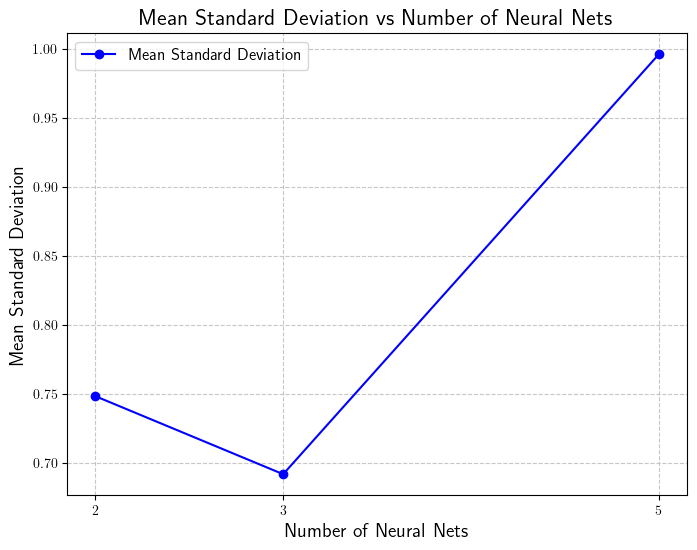

In [81]:
import matplotlib.pyplot as plt

# Prepare data for plotting
nnets_values = list(mean_std_values_by_nnets.keys())  # Number of neural nets
mean_std_values = list(mean_std_values_by_nnets.values())  # Mean standard deviations

# Plot Mean Standard Deviations vs Number of Neural Nets
plt.figure(figsize=(8, 6))
plt.plot(nnets_values, mean_std_values, 'o-', color='blue', label='Mean Standard Deviation')
plt.xlabel('Number of Neural Nets', fontsize=14)
plt.ylabel('Mean Standard Deviation', fontsize=14)
plt.title('Mean Standard Deviation vs Number of Neural Nets', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(nnets_values)  # Ensure ticks match the nnets values
plt.show()

In [83]:
# List of different nnets values to test
nnets_values = [3,5,10,15]

# Dictionary to store the trained models for each number of neural nets
models = {}

# Loop through different numbers of neural nets
for nns in nnets_values:
    print(f"\n--- Training with {nns} neural nets ---")

    # Set the number of nets in the fitter
    f = g.fitter.NeuralFitter(
        fitpoints, th2, nnets=nns, nbatch=50, batchlen=5, 
        regularization='L2', lx_lambda=0.001
    )

    # Fit the model with the current number of nets
    f.fit()

    # Save the trained model for the current nnets value
    model_filename = f'Test_dataset3_nnets_{nns}.tar'
    torch.save(th2.nets, model_filename)
    print(f"Model with {nns} neural nets saved as {model_filename}")

    # Store the model filename in the dictionary for future reference
    models[nns] = model_filename

# Print summary of saved models
print("\nSaved models:")
for nns, filename in models.items():
    print(f"Number of Neural Nets: {nns}, File: {filename}")


--- Training with 3 neural nets ---


/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch   5: train error = 7.4526 test error = 7.8950 -
Epoch  10: train error = 3.4830 test error = 3.1766 -
Epoch  15: train error = 2.1342 test error = 1.8063 -
Epoch  20: train error = 1.8225 test error = 1.7752 -
Epoch  25: train error = 1.7440 test error = 1.9405 +
Epoch  30: train error = 1.7088 test error = 1.9834 +
Epoch  35: train error = 1.6851 test error = 2.0412 +
Epoch  40: train error = 1.6618 test error = 2.0885 +
Epoch  45: train error = 1.6488 test error = 2.0728 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.7752003671297867

Epoch   5: train error = 6.7834 test error = 6.5138 -
Epoch  10: train error = 4.1496 test error = 2.9797 -
Epoch  15: train error = 2.0373 test error = 2.6773 -
Epoch  20: train error = 1.5460 test error = 1.7458 -
Epoch  25: train error = 1.4818 test error = 1.7110 -
Epoch  30: train error = 1.4558 test error = 1.7003 -
Epoch  35: train error = 1.4381 test error = 1.7428 +
Epoch  40: train error = 1.4253 test error = 1.6

In [84]:
# List of saved model filenames (as created in the earlier step)
model_filenames = {
    3: 'Test_dataset3_nnets_3.tar',
    5: 'Test_dataset3_nnets_5.tar',
    10: 'Test_dataset3_nnets_10.tar',
    15: 'Test_dataset3_nnets_15.tar',
}

D = []
std_values_by_nnets = {}  # Stores standard deviations by number of neural nets
mean_std_values_by_nnets = {}  # Stores mean standard deviations for each nnets

# Loop through the saved models
for nns, filename in model_filenames.items():
    print(f"\n--- Loading model with {nns} neural nets from {filename} ---")
    
    # Load the saved model
    th2.nets = torch.load(filename)
    
    std_values = []  # Stores standard deviations for the current model
    A = []  # Temporary storage for current model data
    
    print(f"\n---- [th2 - {nns} neural nets] ----")
    for pt in ptts[::-1]:  # Loop over kinematic points
        Ds = []
        for i, net in enumerate(th2.nets):  # Loop over neural networks
            th2.nn_model, th2.nn_mean, th2.nn_std = net  # Assign neural net parameters
            Ds.append(float(th2.m.subtraction(pt).detach().numpy() * 18. / 25.))
            th2.cffs_evaluated = False  # Reset evaluation flag for each net

        Ds = np.array(Ds)
        D_std = Ds.std()
        std_values.append(D_std)  # Collect standard deviation for the current point
        
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), D_std))
        A.append((pt.tm, Ds.mean(), D_std))

    # Compute mean standard deviation for the current model
    mean_std = np.mean(std_values)
    mean_std_values_by_nnets[nns] = mean_std
    std_values_by_nnets[nns] = std_values

    print(f"\nMean Standard Deviation for {nns} Neural Nets: {mean_std} (using {len(th2.nets)} Neural Nets)")
    th2.m.parameters['nnet'] = 'ALL'  # Reset to use all nets
    D.append(A)

# Display final mean standard deviations for all models
print("\nFinal Results:")
for nns, mean_std in mean_std_values_by_nnets.items():
    print(f"Number of Neural Nets: {nns}, Mean Standard Deviation: {mean_std}")

# Save the collected data for future use
np.save('std_values_by_nnets.npy', std_values_by_nnets)
np.save('mean_std_values_by_nnets.npy', mean_std_values_by_nnets)



--- Loading model with 3 neural nets from Test_dataset3_nnets_3.tar ---

---- [th2 - 3 neural nets] ----
0.185, -0.5: -0.31583719700574875 +- 1.2328712674836395
0.185, -0.4555555555555556: -0.34718136861920357 +- 1.1444303119072028
0.185, -0.4111111111111111: -0.4297189572826028 +- 1.0280407580973527
0.185, -0.3666666666666667: -0.5402828425479432 +- 0.9372306522022958
0.185, -0.32222222222222224: -0.6768722461226085 +- 0.8731757539349363
0.185, -0.2777777777777778: -0.8520498132954041 +- 0.8240081185624988
0.185, -0.23333333333333334: -1.0666749825080235 +- 0.8034568580679335
0.185, -0.18888888888888888: -1.2977184060340126 +- 0.8272821516397074
0.185, -0.14444444444444446: -1.5171091239899397 +- 0.8843206821231695
0.185, -0.1: -1.7290636443843443 +- 0.9690358980324878

Mean Standard Deviation for 3 Neural Nets: 0.9523852452051222 (using 24 Neural Nets)

--- Loading model with 5 neural nets from Test_dataset3_nnets_5.tar ---

---- [th2 - 5 neural nets] ----
0.185, -0.5: -0.4328677921

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_44418/3800127232.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th2.m.subtraction(pt).detach().numpy() * 18. / 25.))


0.185, -0.23333333333333334: -1.3019226223782256 +- 0.8524128223572517
0.185, -0.18888888888888888: -1.530252149052642 +- 0.9228077760073644
0.185, -0.14444444444444446: -1.775662443842049 +- 1.0175211430359647
0.185, -0.1: -2.013735784976571 +- 1.1612673409387448

Mean Standard Deviation for 15 Neural Nets: 0.9064704551418817 (using 54 Neural Nets)

Final Results:
Number of Neural Nets: 3, Mean Standard Deviation: 0.9523852452051222
Number of Neural Nets: 5, Mean Standard Deviation: 0.9289807074212565
Number of Neural Nets: 10, Mean Standard Deviation: 0.934174378291463
Number of Neural Nets: 15, Mean Standard Deviation: 0.9064704551418817


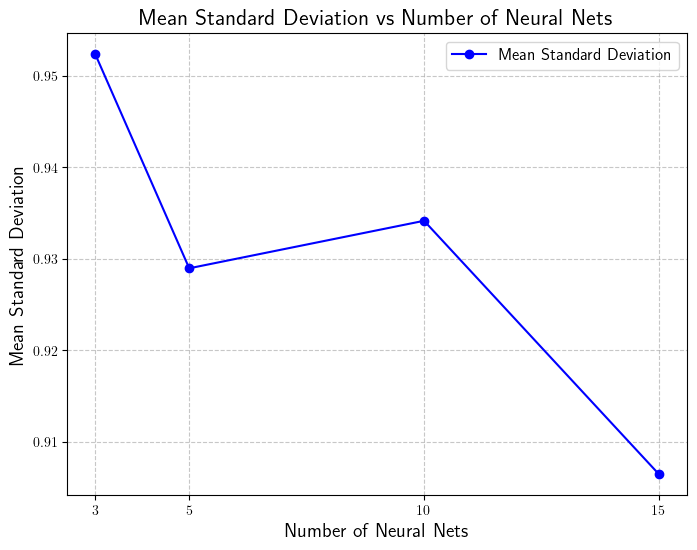

In [85]:
import matplotlib.pyplot as plt

# Prepare data for plotting
nnets_values = list(mean_std_values_by_nnets.keys())  # Number of neural nets
mean_std_values = list(mean_std_values_by_nnets.values())  # Mean standard deviations

# Plot Mean Standard Deviations vs Number of Neural Nets
plt.figure(figsize=(8, 6))
plt.plot(nnets_values, mean_std_values, 'o-', color='blue', label='Mean Standard Deviation')
plt.xlabel('Number of Neural Nets', fontsize=14)
plt.ylabel('Mean Standard Deviation', fontsize=14)
plt.title('Mean Standard Deviation vs Number of Neural Nets', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(nnets_values)  # Ensure ticks match the nnets values
plt.show()

In [86]:
# List of different nnets values to test
nnets_values = [3,5,10,15,20]

# Dictionary to store the trained models for each number of neural nets
models = {}

# Loop through different numbers of neural nets
for nns in nnets_values:
    print(f"\n--- Training with {nns} neural nets ---")

    # Set the number of nets in the fitter
    f = g.fitter.NeuralFitter(
        fitpoints, th2, nnets=nns, nbatch=50, batchlen=5, 
        regularization='L2', lx_lambda=0.001
    )

    # Fit the model with the current number of nets
    f.fit()

    # Save the trained model for the current nnets value
    model_filename = f'Test_dataset3_nnets_{nns}.tar'
    torch.save(th2.nets, model_filename)
    print(f"Model with {nns} neural nets saved as {model_filename}")

    # Store the model filename in the dictionary for future reference
    models[nns] = model_filename

# Print summary of saved models
print("\nSaved models:")
for nns, filename in models.items():
    print(f"Number of Neural Nets: {nns}, File: {filename}")


--- Training with 3 neural nets ---


/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/model.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.standardize(torch.tensor(input_layer, dtype=torch.float32),



Epoch   5: train error = 6.5196 test error = 7.1637 -
Epoch  10: train error = 1.9190 test error = 3.1593 -
Epoch  15: train error = 1.6980 test error = 2.4185 -
Epoch  20: train error = 1.5663 test error = 2.0913 -
Epoch  25: train error = 1.5003 test error = 1.9256 -
Epoch  30: train error = 1.4683 test error = 1.9231 -
Epoch  35: train error = 1.4439 test error = 1.9081 -
Epoch  40: train error = 1.4062 test error = 1.9238 +
Epoch  45: train error = 1.3501 test error = 1.9620 +
Epoch  50: train error = 1.3181 test error = 1.9701 +
Epoch  55: train error = 1.2815 test error = 1.9521 +
Epoch  60: train error = 1.2610 test error = 1.9452 +
No improvement for 5 batches. Stopping early.
Net 0 --> test_err = 1.908110237586672

Epoch   5: train error = 7.6720 test error = 9.4248 -
Epoch  10: train error = 3.2066 test error = 2.7898 -
Epoch  15: train error = 2.0272 test error = 2.3095 -
Epoch  20: train error = 1.6141 test error = 1.7928 -
Epoch  25: train error = 1.4793 test error = 1.74

In [87]:
# List of saved model filenames (as created in the earlier step)
model_filenames = {
    3: 'Test_dataset3_nnets_3.tar',
    5: 'Test_dataset3_nnets_5.tar',
    10: 'Test_dataset3_nnets_10.tar',
    15: 'Test_dataset3_nnets_15.tar',
    20: 'Test_dataset3_nnets_20.tar'
}

D = []
std_values_by_nnets = {}  # Stores standard deviations by number of neural nets
mean_std_values_by_nnets = {}  # Stores mean standard deviations for each nnets

# Loop through the saved models
for nns, filename in model_filenames.items():
    print(f"\n--- Loading model with {nns} neural nets from {filename} ---")
    
    # Load the saved model
    th2.nets = torch.load(filename)
    
    std_values = []  # Stores standard deviations for the current model
    A = []  # Temporary storage for current model data
    
    print(f"\n---- [th2 - {nns} neural nets] ----")
    for pt in ptts[::-1]:  # Loop over kinematic points
        Ds = []
        for i, net in enumerate(th2.nets):  # Loop over neural networks
            th2.nn_model, th2.nn_mean, th2.nn_std = net  # Assign neural net parameters
            Ds.append(float(th2.m.subtraction(pt).detach().numpy() * 18. / 25.))
            th2.cffs_evaluated = False  # Reset evaluation flag for each net

        Ds = np.array(Ds)
        D_std = Ds.std()
        std_values.append(D_std)  # Collect standard deviation for the current point
        
        print("{}, {}: {} +- {}".format(pt.xB, pt.t, Ds.mean(), D_std))
        A.append((pt.tm, Ds.mean(), D_std))

    # Compute mean standard deviation for the current model
    mean_std = np.mean(std_values)
    mean_std_values_by_nnets[nns] = mean_std
    std_values_by_nnets[nns] = std_values

    print(f"\nMean Standard Deviation for {nns} Neural Nets: {mean_std} (using {len(th2.nets)} Neural Nets)")
    th2.m.parameters['nnet'] = 'ALL'  # Reset to use all nets
    D.append(A)

# Display final mean standard deviations for all models
print("\nFinal Results:")
for nns, mean_std in mean_std_values_by_nnets.items():
    print(f"Number of Neural Nets: {nns}, Mean Standard Deviation: {mean_std}")

# Save the collected data for future use
np.save('std_values_by_nnets.npy', std_values_by_nnets)
np.save('mean_std_values_by_nnets.npy', mean_std_values_by_nnets)



--- Loading model with 3 neural nets from Test_dataset3_nnets_3.tar ---

---- [th2 - 3 neural nets] ----
0.185, -0.5: -0.5423267636644212 +- 0.9378222843520146
0.185, -0.4555555555555556: -0.6065479883630025 +- 0.888168931700505
0.185, -0.4111111111111111: -0.7099237559003788 +- 0.828200197927944
0.185, -0.3666666666666667: -0.8331968394810694 +- 0.7950384418454288
0.185, -0.32222222222222224: -0.9669703015763509 +- 0.7900848200905934
0.185, -0.2777777777777778: -1.1211485574512106 +- 0.803381084870175
0.185, -0.23333333333333334: -1.3212740638276987 +- 0.83783246145856
0.185, -0.18888888888888888: -1.5454074011690784 +- 0.904093207453161
0.185, -0.14444444444444446: -1.7842425522312784 +- 0.9955609081949692
0.185, -0.1: -2.0157539368721475 +- 1.136947616990599

Mean Standard Deviation for 3 Neural Nets: 0.8917129954883949 (using 57 Neural Nets)

--- Loading model with 5 neural nets from Test_dataset3_nnets_5.tar ---

---- [th2 - 5 neural nets] ----
0.185, -0.5: -0.5729916178651394 +-

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_44418/1741155843.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds.append(float(th2.m.subtraction(pt).detach().numpy() * 18. / 25.))


0.185, -0.14444444444444446: -1.8983849341109875 +- 1.0399338646953147
0.185, -0.1: -2.147365695526523 +- 1.189675321639055

Mean Standard Deviation for 5 Neural Nets: 0.9226446890332609 (using 62 Neural Nets)

--- Loading model with 10 neural nets from Test_dataset3_nnets_10.tar ---

---- [th2 - 10 neural nets] ----
0.185, -0.5: -0.573225579638448 +- 0.9077378067686138
0.185, -0.4555555555555556: -0.6372516780781249 +- 0.8645667348374712
0.185, -0.4111111111111111: -0.7330679388509856 +- 0.8096438475594874
0.185, -0.3666666666666667: -0.8481300251247982 +- 0.7798674511170068
0.185, -0.32222222222222224: -0.9764717476338975 +- 0.7816036869498734
0.185, -0.2777777777777778: -1.1297270410901143 +- 0.7985789123576904
0.185, -0.23333333333333334: -1.3555693570524454 +- 0.8532278620392871
0.185, -0.18888888888888888: -1.6032120993671317 +- 0.9472495273430968
0.185, -0.14444444444444446: -1.8582444092672732 +- 1.0631716139345169
0.185, -0.1: -2.104923971411255 +- 1.2191193548388626

Mean Sta

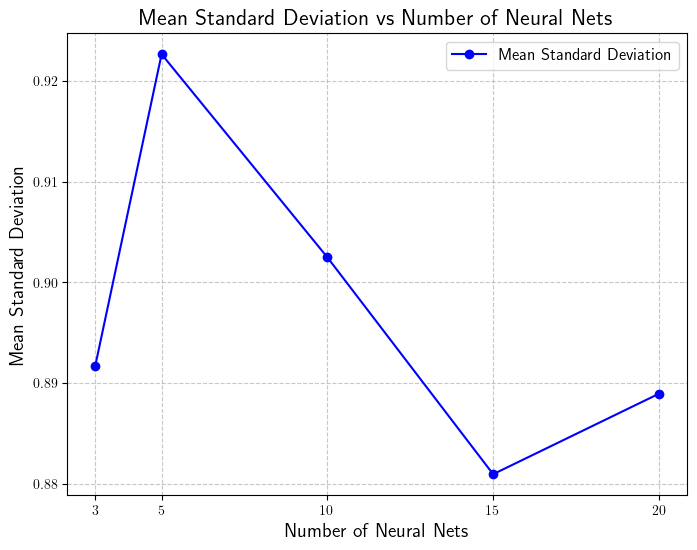

In [88]:
import matplotlib.pyplot as plt

# Prepare data for plotting
nnets_values = list(mean_std_values_by_nnets.keys())  # Number of neural nets
mean_std_values = list(mean_std_values_by_nnets.values())  # Mean standard deviations

# Plot Mean Standard Deviations vs Number of Neural Nets
plt.figure(figsize=(8, 6))
plt.plot(nnets_values, mean_std_values, 'o-', color='blue', label='Mean Standard Deviation')
plt.xlabel('Number of Neural Nets', fontsize=14)
plt.ylabel('Mean Standard Deviation', fontsize=14)
plt.title('Mean Standard Deviation vs Number of Neural Nets', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(nnets_values)  # Ensure ticks match the nnets values
plt.show()


---- [DR in NN whit 2 CFFs - N/A] ----
Net 0: Std. Dev = 1.137390776538401
Net 1: Std. Dev = 0.8728198047636343
Net 2: Std. Dev = 0.7294841827970794
Net 3: Std. Dev = 0.4418804664095048
Net 4: Std. Dev = 0.41420691974250284
Net 5: Std. Dev = 0.07419863393768615
Net 6: Std. Dev = 0.426482006237738
Net 7: Std. Dev = 1.3136616982607838
Net 8: Std. Dev = 0.6617462838824029
Net 9: Std. Dev = 0.6996433141150821

Mean Standard Deviation Across All Nets: 0.6771514086684816


/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_44418/1609593133.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ds = [float(th.m.subtraction(pt).detach().numpy() * 18. / 25.) for pt in ptts[::-1]]


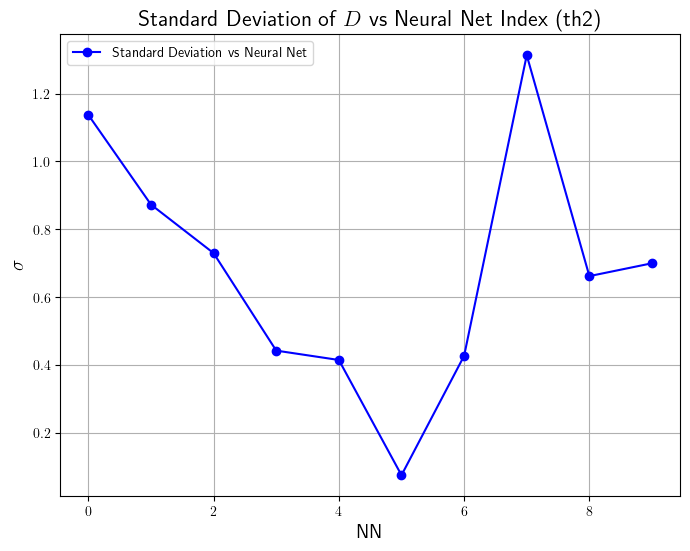

In [74]:
# Initialize storage for standard deviations and corresponding neural net indices
std_values = []
net_indices = []

# Analyze th2
for th in [th2]:
    print("\n---- [{} - {}] ----".format(th.name, th.description))
    for i, net in enumerate(th.nets):  # Loop over neural networks
        th.nn_model, th.nn_mean, th.nn_std = net

        # Compute D values for all points in ptts for the current net
        Ds = [float(th.m.subtraction(pt).detach().numpy() * 18. / 25.) for pt in ptts[::-1]]
        
        # Compute standard deviation for the current net
        Ds = np.array(Ds)
        D_mean = Ds.mean()
        D_std = Ds.std()

        # Store the standard deviation and corresponding net index
        std_values.append(D_std)
        net_indices.append(i)

        print(f"Net {i}: Std. Dev = {D_std}")

    mean_std = np.mean(std_values)
    print(f"\nMean Standard Deviation Across All Nets: {mean_std}")   

# Plot the standard deviations vs neural net indices
plt.figure(figsize=(8, 6))
plt.plot(net_indices, std_values, 'o-', color='blue', label='Standard Deviation vs Neural Net')
plt.xlabel('NN', fontsize=14)
plt.ylabel(r'$\sigma$', fontsize=14)
plt.title('Standard Deviation of $D$ vs Neural Net Index (th2)', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()


## Pressure Distribution
### Code for pressure in terms of D-term

(-2.0, 0.0)

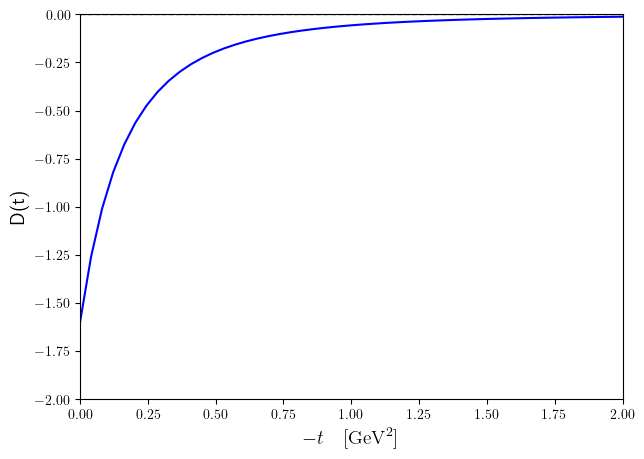

In [52]:
# Plotting this D-term
fig, ax = plt.subplots(1, 1, figsize=[7,5])
tms = np.linspace(0,2)
ax.plot(tms, Dterm(-tms), 'b-')
ax.set_ylabel(r'D(t)', fontsize=14)
ax.set_xlabel(r'$-t\quad[{\rm GeV}^2]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-2,0)
# fig.savefig('figs/dterm.pdf')

In [53]:
def pressureNnaive(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [54]:
def pressureN(r, Dterm, **args):
    """Pressure distribution r^2*p(r) in GeV/fm for given Dterm(t) function"""
    GeVfm = 0.197
    Mp = 0.938
    rGeV = r/GeVfm
    # variable change x=-t^2, so QUADPACK Fourier integral method can be used
    intg = quad(lambda x: 2*x*(-x**2)*Dterm(-x**2, **args), 0, np.inf, weight='sin', wvar=rGeV)
    return intg[0]/(24*np.pi**2*Mp*rGeV) * rGeV**2 / GeVfm

In [55]:
def pressureA(r, D0=-1.6, M=0.7, p=3):
    """Pressure distribution r^2*p(r) in GeV/fm for specific Dterm(t) function
    
     D(t) = D0/(1-t/M^2)^p  with p=2 or 3
    
    """
    GeVfm = 0.197
    Mp = 0.938
    assert p in [2,3]
    rGeV = r/GeVfm
    res = D0 * M**(2+p) * rGeV**(p-3) * np.exp(-M*rGeV) * (M*rGeV - p)
    return rGeV**2 * res / (2**(2*p) * 3 * np.pi * Mp) / GeVfm


In [56]:
D0val, Mval, pval = -1.6, 0.7, 3
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_44418/398589812.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)


(np.float64(0.0037265359461670666), 0.003726545962032528, 0.00372653594438695)

In [57]:
D0val, Mval, pval = -1.6, 1.3, 2
pressureA(0.3, D0=D0val, M=Mval, p=pval), pressureNnaive(0.3, Dterm, D0=D0val, M=Mval, p=pval), pressureN(0.3, Dterm, D0=D0val, M=Mval, p=pval)

/var/folders/qr/2k2591d90wjb4sqtmlttw7r40000gq/T/ipykernel_44418/398589812.py:6: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = quad(lambda t: np.sin(np.sqrt(-t)*rGeV)*t*Dterm(t, **args), -np.inf, 0, epsabs=0)


(np.float64(0.0007003436725664407),
 -0.027815739561061145,
 0.0007003436730263134)

In [58]:
pressure = pressureN

## Pressure distribution - mean values

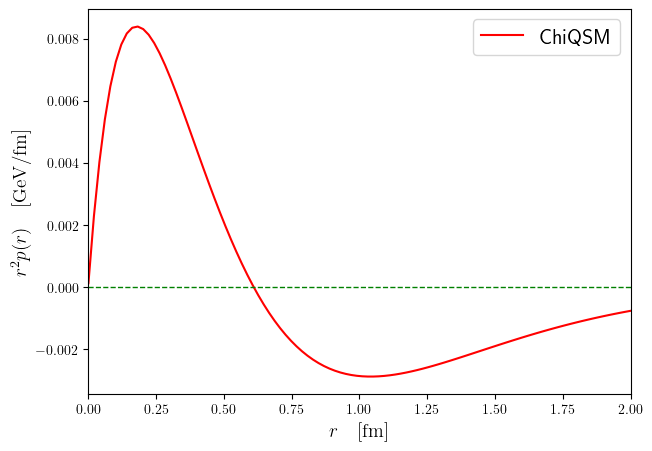

In [59]:
# Plotting the distribution for ChiQSM parameters from hep-ph/0702030
# d_1(0) = -2.35, M = 0.646,  so D(0) = 1.88
fig, ax = plt.subplots(1, 1, figsize=[7,5])
rs = np.linspace(0.001,2,100)
ps = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=-1.88, M=0.646, p=2))
ax.plot(rs, ps, 'r-', label='ChiQSM')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
#fig.savefig('figs/pressure.pdf')

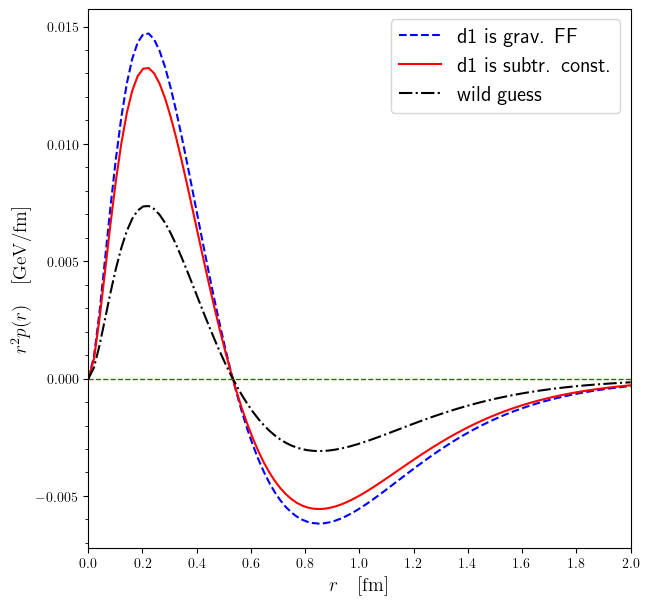

In [60]:
Mval = np.sqrt(1.06)
D0val = -2.04 * (4./5.) # d_1 is grav. form. fact.
D0valA = -2.04 * (18./25.)  # d_1 is subtr. const
D0valB = -2.04 * (18./25.)*(5./9.)  # wild guess
fig, ax = plt.subplots(1, 1, figsize=[7,7])
rs = np.linspace(0.001,2,100)
ps = []
psA = []
psB = []
for r in rs:
    ps.append(pressure(r, Dterm, D0=D0val, M=Mval, p=2.76))   
    psA.append(pressure(r, Dterm, D0=D0valA, M=Mval, p=2.76))
    psB.append(pressure(r, Dterm, D0=D0valB, M=Mval, p=2.76))
ax.plot(rs, ps, 'b--', label='d1 is grav. FF')
ax.plot(rs, psA, 'r-', label='d1 is subtr. const.')
ax.plot(rs, psB, 'k-.', label='wild guess')
ax.set_ylabel(r'$r^2 p(r) \quad[{\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.001))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.2))

### Pressure distribution - uncertainties

In [61]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = np.sqrt(0.14**2 + 0.33**2) * (18./25.)*(5./9.)
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [62]:
# Sampling from Gaussian/normal distribution using scipy's stats routines
ss = 50 #  sample size
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [63]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

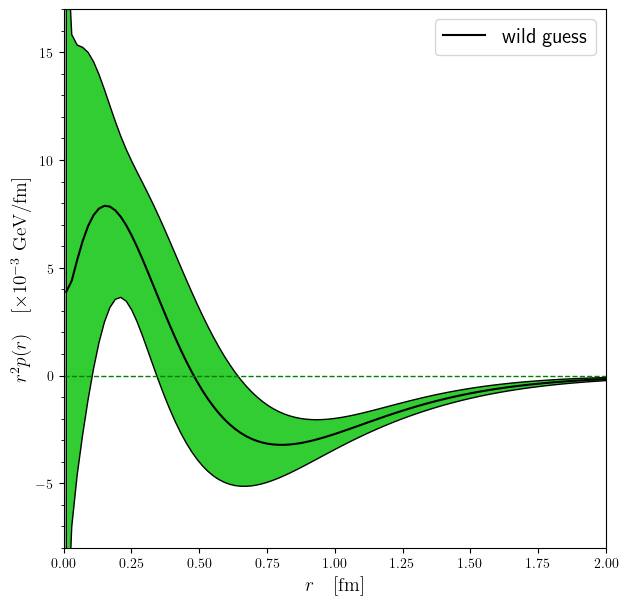

In [64]:
# I need to use "wild guess" option above to get agreement Fig. from Nature
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='limegreen',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#fig.savefig('figs/pressure_nat.pdf')

In [65]:
d0, M, p = -2.04 * (18./25.)*(5./9.), np.sqrt(1.06), 2.76
d0err = 1.4 * (18./25.)  # as seen above, this is essentially t-independent
M2err = np.sqrt(0.1**2 + 0.15**2)
Merr = M2err/2/M
perr = np.sqrt(0.25**2 + 0.5**2)

In [66]:
d0MC = norm.rvs(d0, d0err, size=ss)
MMC = norm.rvs(M, Merr, size=ss)
pMC = norm.rvs(p, perr, size=ss)

In [67]:
rs = np.linspace(0.01,2,100)
psmean = []
psup = []
psdown = []
for r in rs:
    pressMC = []
    for k in range(ss):
        pressMC.append(pressure(r, Dterm, D0=d0MC[k], M=MMC[k], p=pMC[k]))
    mean, std = 1000*np.mean(pressMC), 1000*np.std(pressMC)
    psmean.append(mean)
    psup.append(mean+std)
    psdown.append(mean-std)

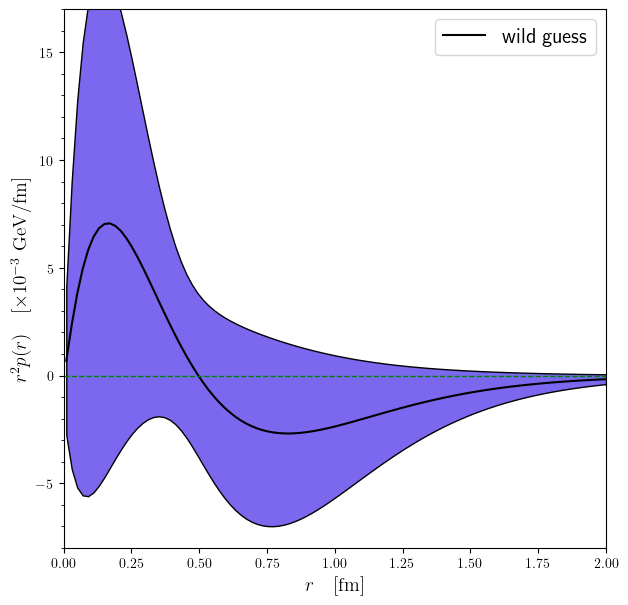

In [68]:
fig, ax = plt.subplots(1, 1, figsize=[7,7])
ax.plot(rs, psmean, 'k-', label='wild guess')
ax.fill_between(rs, psup, psdown,
                    facecolor='mediumslateblue',
                    edgecolor='black', linewidth=1, zorder=0)
ax.set_ylabel(r'$r^2 p(r) \quad[\times 10^{-3}\; {\rm GeV}/{\rm fm}]$', fontsize=14)
ax.set_xlabel(r'$r\quad[{\rm fm}]$', fontsize=14)
ax.axhline(linestyle='--', color='g', lw=1)
ax.set_xlim(0,2)
ax.set_ylim(-8, 17)
ax.legend(loc="upper right", fontsize=15)
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
#fig.savefig('figs/pressure_NNet.pdf')